In [5]:
import glob
import os
import pickle
import time

import numpy as np
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import cv2
import featurelib as lib
import searchlib as searchlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

# Get some data

In [12]:
def generate_data():
    vehicle_images = glob.glob("data/vehicles/**/*.png", recursive=True)
    non_vehicle_images = glob.glob(
        "data/non-vehicles/**/*.png", recursive=True)
    Y = np.hstack((np.ones(len(vehicle_images)),
                   np.zeros(len(non_vehicle_images))))
    X = np.hstack((vehicle_images, non_vehicle_images))
    X, Y = shuffle(X, Y)
    return train_test_split(X, Y, test_size=0.33)


def get_images():
    cars = glob.glob("data/vehicles/**/*.png", recursive=True)
    not_cars = glob.glob("data/non-vehicles/**/*.png", recursive=True)
    return shuffle(cars), shuffle(not_cars)


def train_classifier():
    pickle_file = 'data/svc.p'
    if os.path.exists(pickle_file):
        print("loading pickle file for svc. skipping training", pickle_file)
        obj = pickle.load(open(pickle_file, "rb"))
        return obj['svc'], obj['scaler']

    t1 = time.time()
    print("finding images")
    cars, not_cars = get_images()
    print("extracting features for this many inputs", len(cars) + len(not_cars))
    car_features = lib.extract_features(cars, color_space=color_space,
                                        spatial_size=spatial_size, hist_bins=hist_bins,
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = lib.extract_features(not_cars, color_space=color_space,
                                           spatial_size=spatial_size, hist_bins=hist_bins,
                                           orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block,
                                           hog_channel=hog_channel, spatial_feat=spatial_feat,
                                           hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:', orient, 'orientations', pix_per_cell,
          'pixels per cell and', cell_per_block, 'cells per block')
    print('Feature vector length:', len(X_train[0]))
    t2 = time.time()
    print("Time to extract features", round(t2 - t1, 2))
    # Use a linear SVC
    svc = LinearSVC(C=svc_C)
    svc.fit(X_train, y_train)
    t3 = time.time()
    print(round(t3 - t2, 2), 'Seconds to train SVC...')

    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("Saving svc to pickle file")
    pickle.dump({'svc': svc, 'scaler': X_scaler}, open(pickle_file, 'wb'))

    return svc, X_scaler


def process_frame(image, svc, X_scaler, scale, y_start_stop, heatmap):
    bboxes = []
    # searchlib.find_cars(image, y_start_stop[0]+50, y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    # searchlib.find_cars(image, y_start_stop[0], y_start_stop[0]+100, scale/1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    # searchlib.find_cars(image, 550, 700, scale * 1.33333, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    searchlib.find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    searchlib.find_cars(image, y_start_stop[0], y_start_stop[1], scale * 1.333333, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    searchlib.find_cars(image, y_start_stop[0], y_start_stop[1], scale * 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    draw_image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

    heatmap.add_heat(image, bboxes)
    #return searchlib.draw_boxes(draw_image, bboxes)
    return searchlib.draw_labeled_bboxes(draw_image, heatmap.get_labelled_map())

class HeatMap():
    def __init__(self, threshold, count_to_keep):
        self.current = None
        self.history = []
        self.avg_heatmap = None
        self.threshold = threshold
        self.count_to_keep = count_to_keep

    def add_heat(self, image, bbox_list):
        self.current = np.zeros_like(image[:, :, 0]).astype(np.float)
        heatmap = self.current
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.history.append(heatmap)
        # keep only the last 5 items
        self.history = self.history[-self.count_to_keep:]
        self.avg_heatmap = np.clip(np.sum(self.history, axis=0), 0, 255)
        self.avg_heatmap[self.avg_heatmap <= self.threshold] = 0


    def get_labelled_map(self):
        return label(self.avg_heatmap)


def main():
    svc, X_scaler = train_classifier()
    y_start_stop = [400, 700]
    scale = 1.5
    heatmap = HeatMap(heatmap_threshold, heatmap_count_to_keep)

    # test_files = glob.glob("test_images/*.jpg")
    # for file in test_files:
    #     image = lib.read_image_in_colorspace(file, color_space="YCrCb")

    #     t4 = time.time()
    #     out_img = process_frame(image, svc, X_scaler, scale, y_start_stop, heatmap)
    #     t5 = time.time()
    #     print("Displaying image.... Press space to exit ", round(t5-t4, 2))
    #     cv2.imshow('image', cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))
    #     cv2.waitKey(0)
    # return

    #test_videos = ['test_video.mp4']
    test_videos = ['project_video.mp4']

    for vid_file in test_videos:
        clip = VideoFileClip(vid_file)
        output_clip = clip.fl_image(
            lambda img: process_frame(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb), svc, X_scaler, scale, y_start_stop, heatmap))
        output_clip.write_videofile(
            'output_' + vid_file, audio=False, threads=4)

# --------- Tuning Parameters ---------
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
svc_C = 1.0
heatmap_count_to_keep = 8
heatmap_threshold = np.int(1.5 * heatmap_count_to_keep)

## Exploring the data set

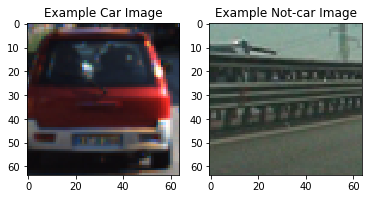

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def explore_set():
    cars, notcars = get_images()
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])


    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

explore_set()

loading pickle file for svc. skipping training data/svc.p
Displaying image....  0.58


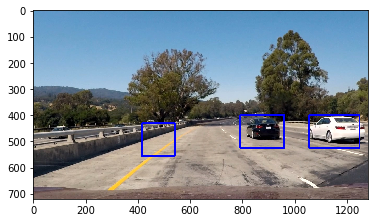

Displaying image....  0.57


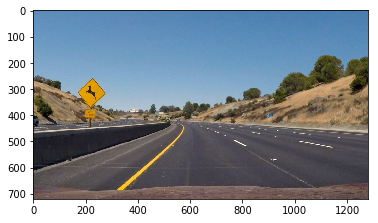

Displaying image....  0.61


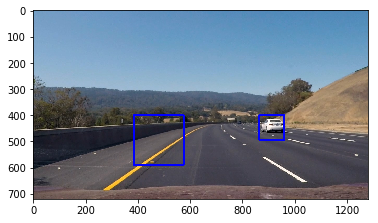

Displaying image....  0.59


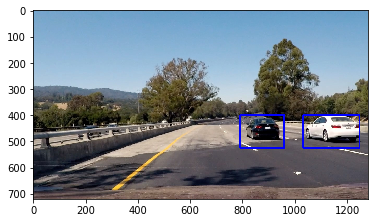

Displaying image....  0.59


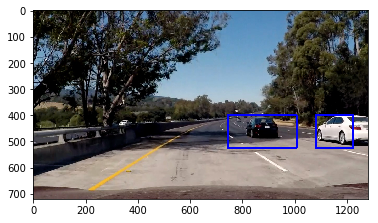

Displaying image....  0.59


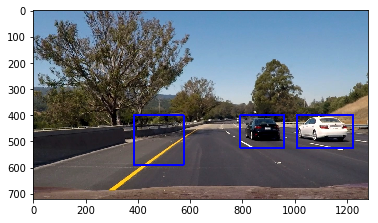

In [28]:
def process_frame_test(image, svc, X_scaler, scale, y_start_stop, heatmap):
    bboxes = []
    # searchlib.find_cars(image, y_start_stop[0]+50, y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    # searchlib.find_cars(image, y_start_stop[0], y_start_stop[0]+100, scale/1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    # searchlib.find_cars(image, 550, 700, scale * 1.33333, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    searchlib.find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    searchlib.find_cars(image, y_start_stop[0], y_start_stop[1], scale * 1.333333, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    searchlib.find_cars(image, y_start_stop[0], y_start_stop[1], scale * 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bboxes)
    draw_image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

    heatmap.add_heat(image, bboxes)
    return bboxes, draw_image
    #return searchlib.draw_labeled_bboxes(draw_image, heatmap.get_labelled_map())    
def test_window():
    svc, X_scaler = train_classifier()
    y_start_stop = [400, 700]
    scale = 1.5
    heatmap = HeatMap(heatmap_threshold, heatmap_count_to_keep)

    test_files = glob.glob("test_images/*.jpg")
    for file in test_files:
        image = lib.read_image_in_colorspace(file, color_space="YCrCb")
        heatmap = HeatMap(0, 1)
        t4 = time.time()
        bboxes, draw_image = process_frame_test(image, svc, X_scaler, scale, y_start_stop, heatmap)
        copy_draw_image = np.copy(draw_image)
        searchlib.draw_boxes(draw_image, bboxes)
        labeled = heatmap.get_labelled_map()
        searchlib.draw_labeled_bboxes(copy_draw_image, labeled)
        t5 = time.time()
        print("Displaying image.... ", round(t5-t4, 2))
        plt.imshow(copy_draw_image)
        plt.show()
        
#         fig = plt.figure()
#         plt.subplot(121)
#         plt.imshow(draw_image)
#         plt.title('Car Positions')
#         plt.subplot(122)
#         plt.imshow(labeled[0], cmap='gray')
#         plt.title('Labeled heatmap')
#         plt.show()
#         fig.tight_layout()
    return
test_window()